In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [23]:
from read_and_clean import read_and_clean

In [24]:
orders_df = read_and_clean()

In [18]:
orders_df

,Row ID,Order Priority,Discount,Unit Price,Shipping Cost,Customer ID,Customer Name,Ship Mode,Customer Segment,Product Category,...,City,Postal Code,Order Date,Ship Date,Profit,Quantity ordered new,Sales,Order ID,Year,Month
0,20847,High,0.01,2.84,0.93,3,Bonnie Potter,Express Air,Corporate,Office Supplies,...,Anacortes,98221,2015-01-07,2015-01-08,4.5600,4,13.01,88522,2015,1
1,20228,Not Specified,0.02,500.98,26.00,5,Ronnie Proctor,Delivery Truck,Home Office,Furniture,...,San Gabriel,91776,2015-06-13,2015-06-15,4390.3665,12,6362.85,90193,2015,6
2,21776,Critical,0.06,9.48,7.29,11,Marcus Dunlap,Regular Air,Home Office,Furniture,...,Roselle,7203,2015-02-15,2015-02-17,-53.8096,22,211.15,90192,2015,2
3,24844,Medium,0.09,78.69,19.99,14,Gwendolyn F Tyson,Regular Air,Small Business,Furniture,...,Prior Lake,55372,2015-05-12,2015-05-14,803.4705,16,1164.45,86838,2015,5
4,24846,Medium,0.08,3.28,2.31,14,Gwendolyn F Tyson,Regular Air,Small Business,Office Supplies,...,Prior Lake,55372,2015-05-12,2015-05-13,-24.0300,7,22.23,86838,2015,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,19842,High,0.01,10.90,7.46,3397,Andrea Shaw,Regular Air,Small Business,Office Supplies,...,Danville,61832,2015-03-11,2015-03-12,-116.7600,18,207.31,87536,2015,3
1948,19843,High,0.10,7.99,5.03,3397,Andrea Shaw,Regular Air,Small Business,Technology,...,Danville,61832,2015-03-11,2015-03-12,-160.9520,22,143.12,87536,2015,3
1949,26208,Not Specified,0.08,11.97,5.81,3399,Marvin Reid,Regular Air,Small Business,Office Supplies,...,Des Plaines,60016,2015-03-29,2015-03-31,-41.8700,5,59.98,87534,2015,3
1950,24911,Medium,0.10,9.38,4.93,3400,Florence Gold,Express Air,Small Business,Furniture,...,Fairmont,26554,2015-04-04,2015-04-04,-24.7104,15,135.78,87537,2015,4


In [30]:
orders_df.columns

Index(['Row ID', 'Order Priority', 'Discount', 'Unit Price', 'Shipping Cost',
       'Customer ID', 'Customer Name', 'Ship Mode', 'Customer Segment',
       'Product Category', 'Product Sub-Category', 'Product Container',
       'Product Name', 'Product Base Margin', 'Country', 'Region',
       'State or Province', 'City', 'Postal Code', 'Order Date', 'Ship Date',
       'Profit', 'Quantity ordered new', 'Sales', 'Order ID', 'Year', 'Month'],
      dtype='object')

C:\Users\Bartłomiej\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Bartłomiej\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Bartłomiej\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

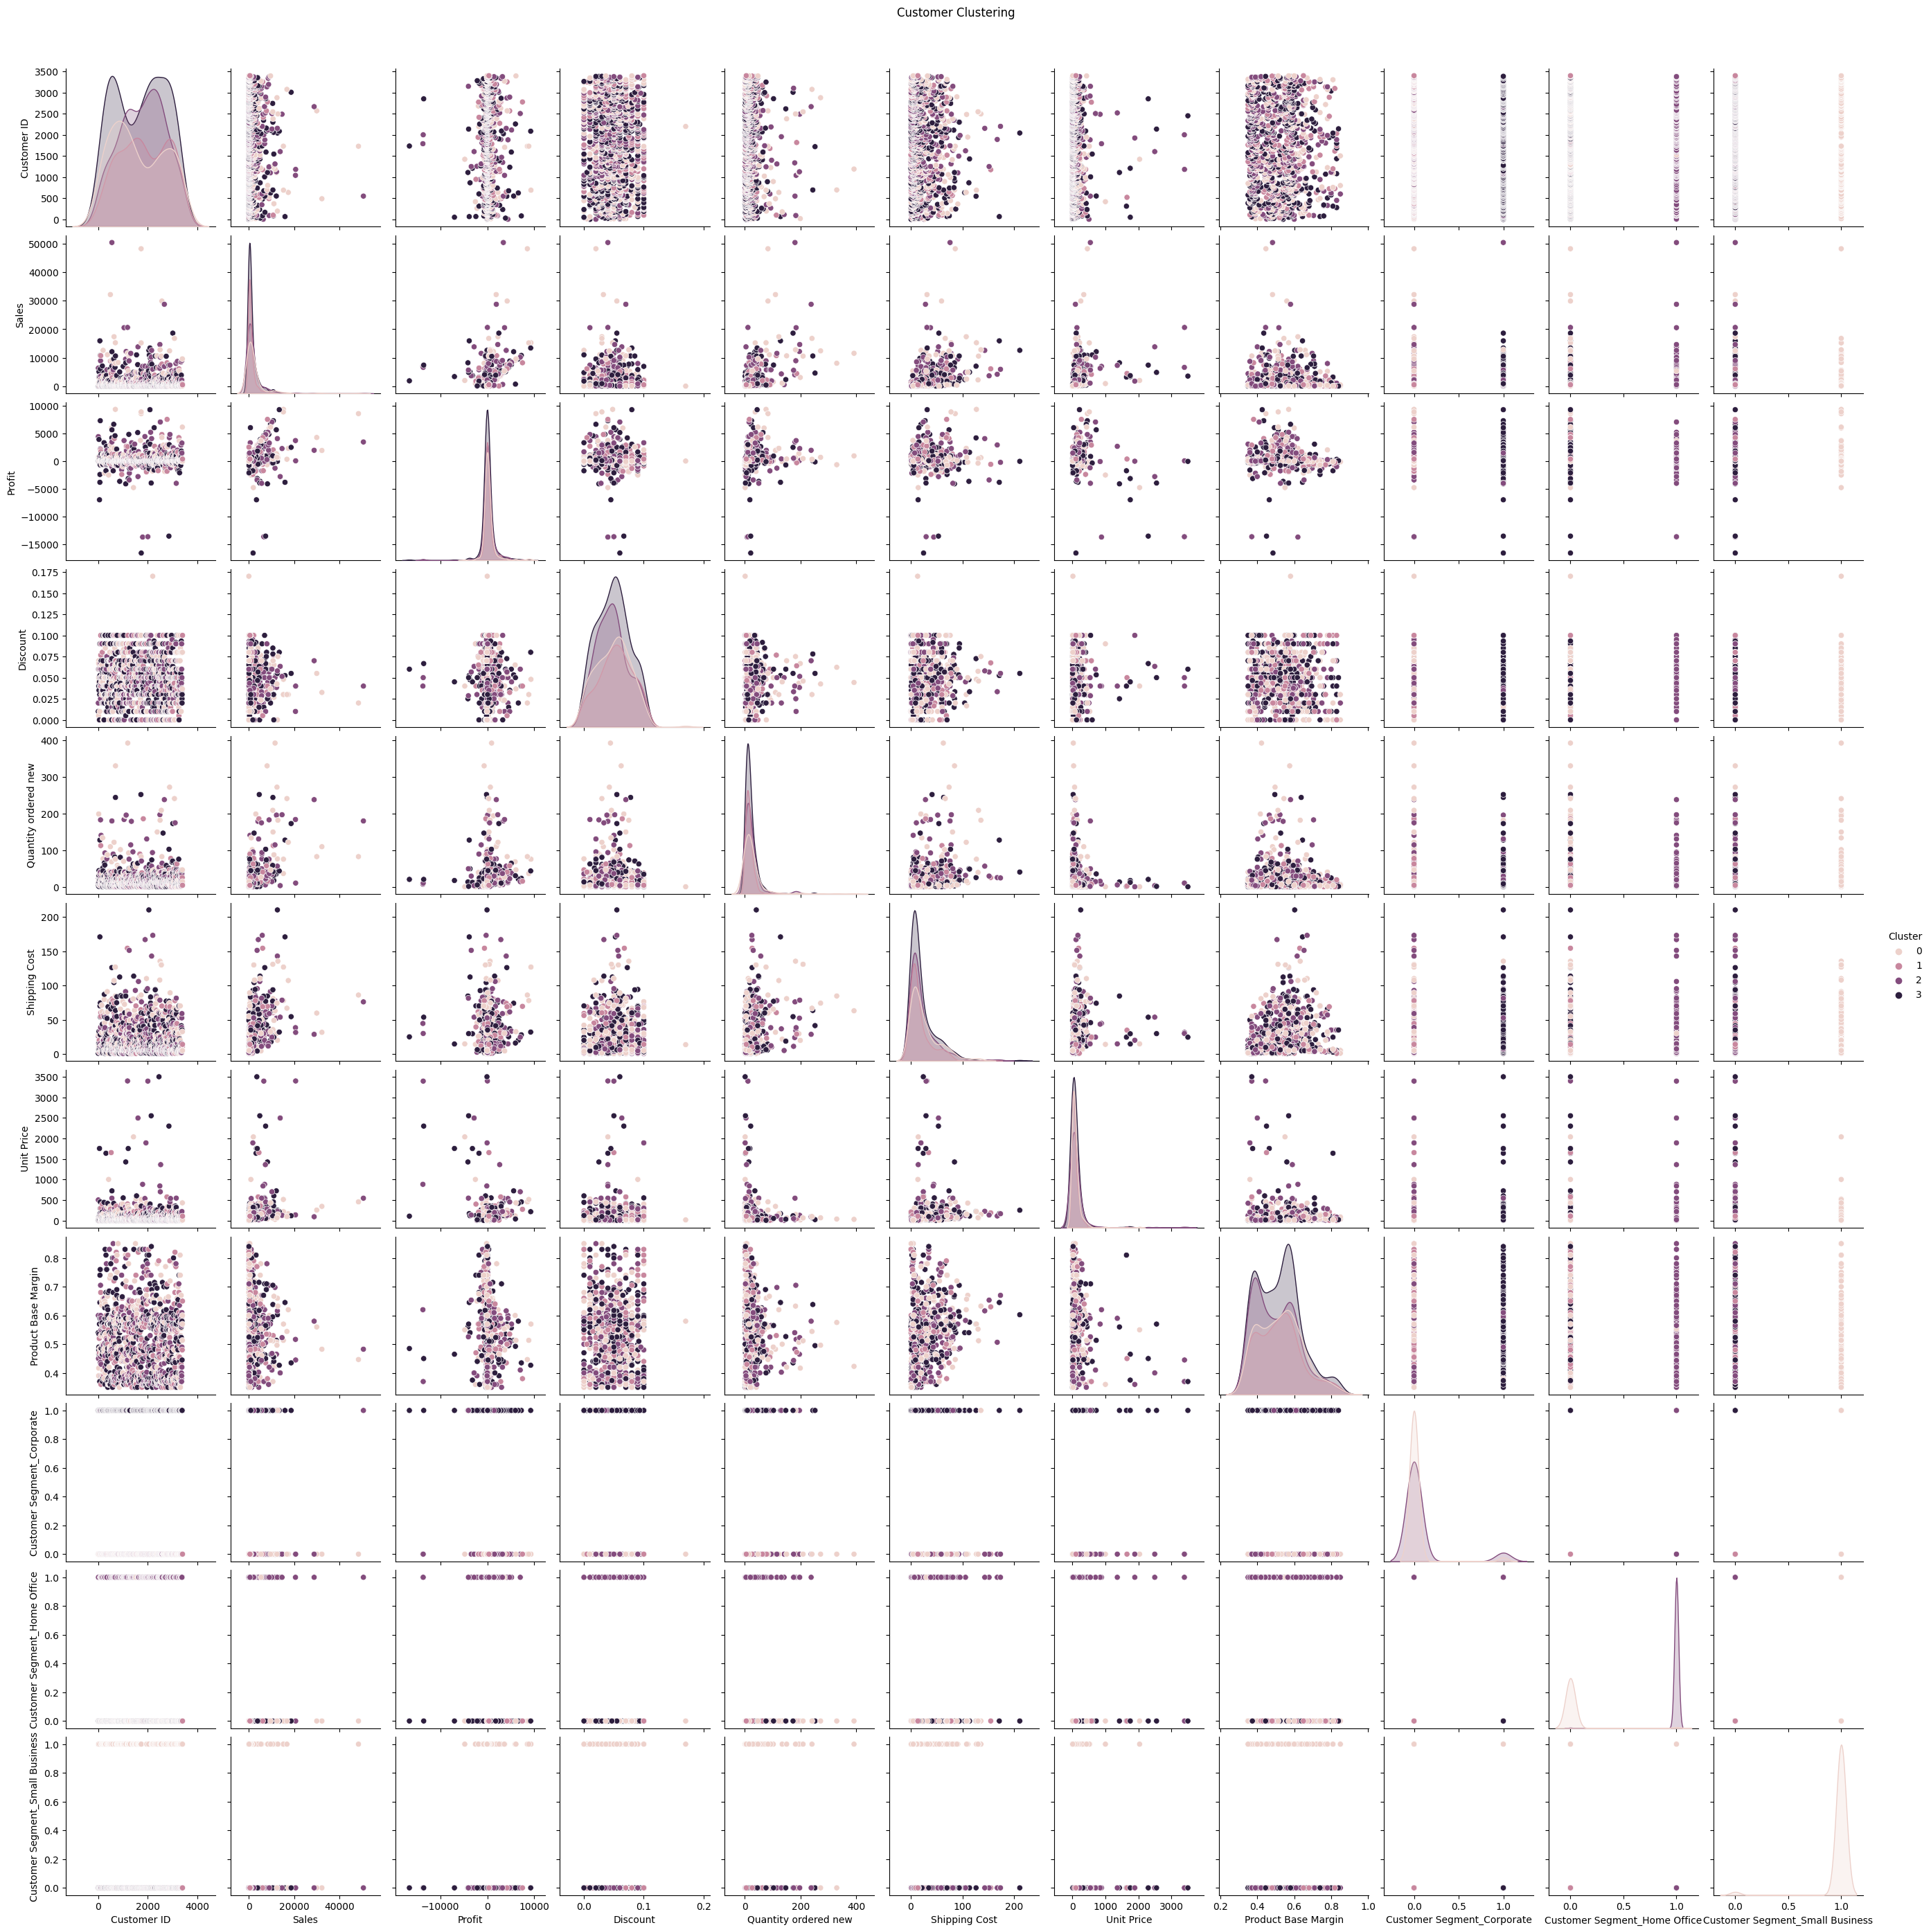

In [42]:
# ----------- Step 1: Aggregate by Customer ----------- #
customer_df = orders_df.groupby('Customer ID').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Discount': 'mean',
    'Quantity ordered new': 'sum',
    'Shipping Cost': 'sum',
    'Unit Price': 'mean',
    'Product Base Margin': 'mean',
}).reset_index()

# Optional: Add encoded segment info
segment_dummies = pd.get_dummies(orders_df[['Customer ID', 'Customer Segment']], drop_first=True)
segment_dummies = segment_dummies.groupby('Customer ID').max().reset_index()
customer_df = pd.merge(customer_df, segment_dummies, on='Customer ID', how='left')

# ----------- Step 2: Scale & Cluster ----------- #
X = customer_df.drop('Customer ID', axis=1)
# Fill NaNs with column mean
X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(X_scaled)

# ----------- Step 3: Visualize ----------- #
sns.pairplot(customer_df, hue='Cluster', diag_kind='kde')
plt.suptitle('Customer Clustering', y=1.02)
plt.show()

In [58]:
# ----------- Step 1: Aggregate by Product ----------- #
product_df = orders_df.groupby('Product Name').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Discount': 'mean',
    'Quantity ordered new': 'sum',
    'Shipping Cost': 'mean',
    'Unit Price': 'mean',
    'Product Base Margin': 'mean'
}).reset_index()

# Step 1: Select needed columns
product_categories = orders_df[['Product Name', 'Product Category']]

# Step 2: Create dummies separately for 'Product Category'
dummies = pd.get_dummies(product_categories['Product Category'], prefix='Category', drop_first=True)

# Step 3: Concatenate 'Product Name' with dummies
category_dummies = pd.concat([product_categories['Product Name'], dummies], axis=1)

# Step 4: Group by 'Product Name' and aggregate (use max to preserve presence of category)
category_dummies = category_dummies.groupby('Product Name').max().reset_index()

# Step 5: Merge with aggregated product_df
product_df = pd.merge(product_df, category_dummies, on='Product Name', how='left')

# Ensure 'Product Name' is a column, not an index
if 'Product Name' not in product_df.columns:
    product_df = product_df.reset_index()

# ----------- Step 2: Scale & Cluster ----------- #
X_prod = product_df.drop('Product Name', axis=1)
# Fill NaNs with column mean
X_prod = X_prod.fillna(X_prod.mean())

X_prod_scaled = scaler.fit_transform(X_prod)

kmeans_prod = KMeans(n_clusters=4, random_state=42)
product_df['Cluster'] = kmeans_prod.fit_predict(X_prod_scaled)

# ----------- Step 3: Visualize ----------- #
# sns.pairplot(product_df, hue='Cluster', diag_kind='kde')
# plt.suptitle('Product Clustering', y=1.02)
# plt.show()

C:\Users\Bartłomiej\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Bartłomiej\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Bartłomiej\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

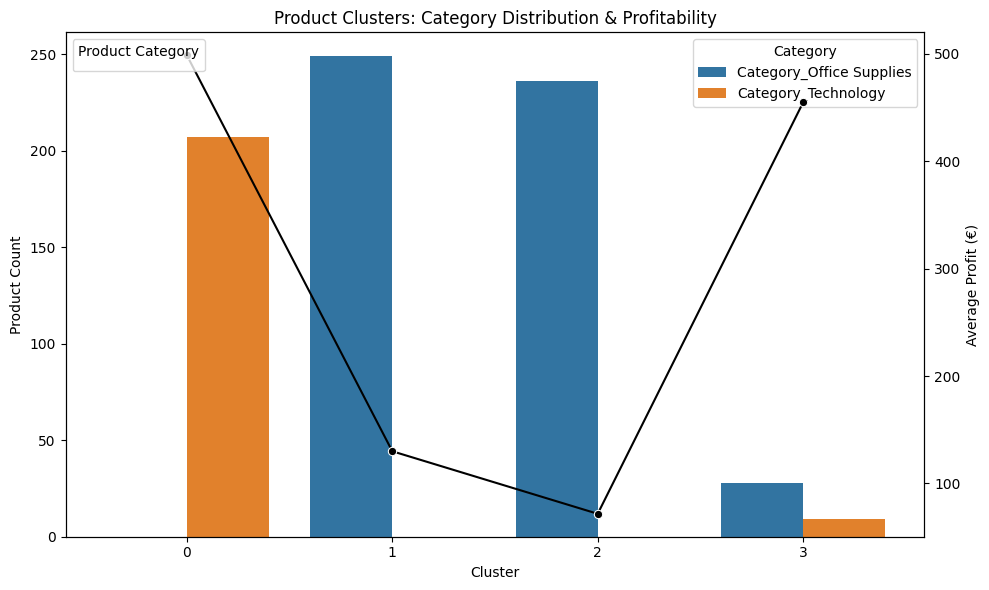

In [61]:
# Prepare cluster-wise profit
cluster_profit = product_df.groupby('Cluster')['Profit'].mean().reset_index()
cluster_profit.columns = ['Cluster', 'Avg_Profit']

# Melt category columns
melted = product_df.melt(
    id_vars=['Cluster'],
    value_vars=['Category_Office Supplies', 'Category_Technology'],
    var_name='Category',
    value_name='IsCategory'
)
melted = melted[melted['IsCategory']]

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart: product count by cluster and category
sns.countplot(data=melted, x='Cluster', hue='Category', ax=ax1)
ax1.set_ylabel('Product Count')
ax1.set_xlabel('Cluster')
ax1.set_title('Product Clusters: Category Distribution & Profitability')

# Line plot: average profit
ax2 = ax1.twinx()
sns.lineplot(data=cluster_profit, x='Cluster', y='Avg_Profit', color='black', marker='o', ax=ax2)
ax2.set_ylabel('Average Profit (€)')

plt.legend(title='Product Category', loc='upper left')
plt.tight_layout()
plt.show()

In [46]:
product_df.groupby('Cluster')[['Sales', 'Profit', 'Discount', 'Quantity ordered new', 'Shipping Cost', 'Unit Price', 'Product Base Margin']].mean().reset_index()

,Cluster,Sales,Profit,Discount,Quantity ordered new,Shipping Cost,Unit Price,Product Base Margin
0,0,2431.523382,498.551403,0.047565,27.763285,8.638510,128.729179,0.557810
1,1,655.049180,129.966460,0.029249,31.308197,6.839328,26.560361,0.460660
2,2,489.462424,71.764143,0.072181,21.007576,6.080821,32.857708,0.465995
3,3,7970.835474,454.685895,0.049290,32.306569,43.361204,357.146569,0.654956


In [5]:
scaler = StandardScaler()
features = scaler.fit_transform(orders_df[['Sales', 'Quantity ordered new', 'Discount', 'Profit']])

kmeans = KMeans(n_clusters=4, random_state=42)
orders_df['Segment'] = kmeans.fit_predict(features)

In [6]:
orders_df['Segment'] 

0       1
1       2
2       0
3       0
4       0
       ..
1947    1
1948    0
1949    0
1950    0
1951    0
Name: Segment, Length: 1952, dtype: int32

In [38]:
customer_df

,Customer ID,Sales,Profit,Discount,Quantity ordered new,Shipping Cost,Unit Price,Product Base Margin,Customer Segment_Corporate,Customer Segment_Home Office,Customer Segment_Small Business,Cluster
0,3,13.01,4.5600,0.010000,4,0.93,2.8400,0.540000,True,False,False,3
1,5,6362.85,4390.3665,0.020000,12,26.00,500.9800,0.600000,False,True,False,2
2,11,211.15,-53.8096,0.060000,22,7.29,9.4800,0.450000,False,True,False,2
3,14,1214.93,741.7005,0.067500,31,28.13,22.2075,0.477500,False,False,True,0
4,15,413.00,202.0557,0.005000,17,11.65,20.1800,0.390000,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1125,3393,790.56,371.3802,0.080000,26,10.19,65.2350,0.480000,False,False,False,1
1126,3397,9603.24,6106.7269,0.036667,47,32.48,429.9600,0.513333,False,False,True,0
1127,3399,59.98,-41.8700,0.080000,5,5.81,11.9700,0.600000,False,False,True,0
1128,3400,135.78,-24.7104,0.100000,15,4.93,9.3800,0.570000,False,False,True,0


In [43]:
customer_df.groupby('Cluster')[['Sales', 'Profit', 'Discount', 'Quantity ordered new', 'Shipping Cost', 'Unit Price', 'Product Base Margin']].mean().reset_index()

,Cluster,Sales,Profit,Discount,Quantity ordered new,Shipping Cost,Unit Price,Product Base Margin
0,0,2248.388074,312.892040,0.049223,28.290984,26.552828,92.536900,0.525547
1,1,1057.980046,243.175115,0.053073,16.611111,18.426620,81.275410,0.520182
2,2,1977.189585,187.419686,0.046233,24.141869,22.266298,125.400291,0.502502
3,3,1511.285328,107.721365,0.048621,20.472441,22.099291,110.238274,0.516719


In [7]:

# Reduce dimensions for visualization using only numeric features used for clustering
pca = PCA(n_components=2)
reduced = pca.fit_transform(features)
orders_df['PCA1'] = reduced[:, 0]
orders_df['PCA2'] = reduced[:, 1]



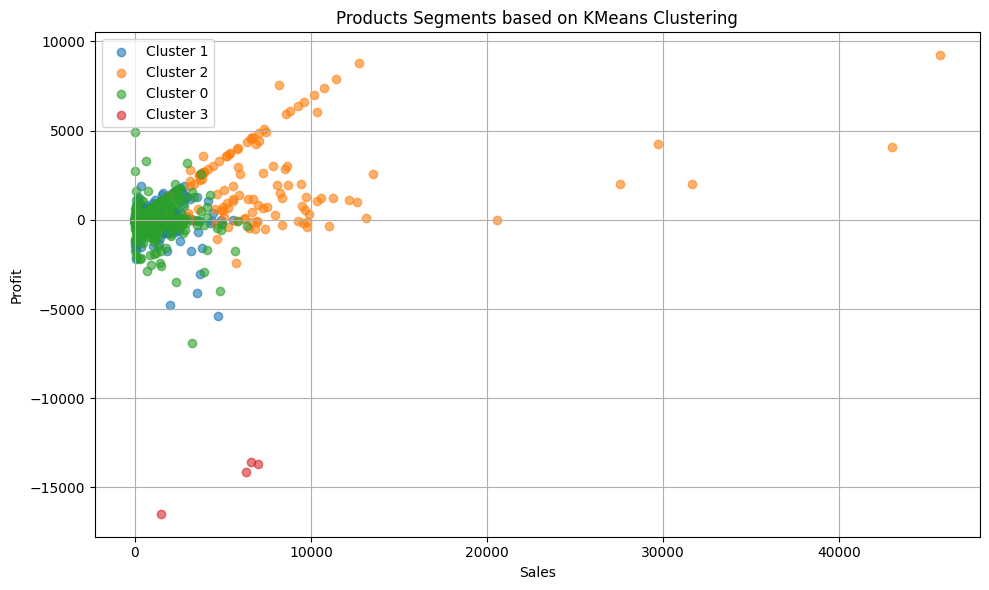

In [8]:
# Plot
plt.figure(figsize=(10, 6))
for cluster in orders_df['Segment'].unique():
    subset = orders_df[orders_df['Segment'] == cluster]
    plt.scatter(subset['Sales'], subset['Profit'], label=f'Cluster {cluster}', alpha=0.6)

plt.title('Products Segments based on KMeans Clustering')
plt.xlabel('Sales')
plt.ylabel('Profit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# Prepare data for basket analysis
orders_subset = orders_df[['Order ID', 'Product Name']].dropna()
basket = orders_subset.groupby('Order ID')['Product Name'].apply(list)

# Encode transactions to one-hot format
te = TransactionEncoder()
te_ary = te.fit_transform(basket)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Find frequent itemsets
frequent_itemsets = apriori(df_encoded, min_support=0.005, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=1.2)

# Show results
rules_sorted = rules.sort_values(by='lift', ascending=False)
rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)

,antecedents,consequents,support,confidence,lift


In [ ]:
rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)